### Network Traffic Classification: Feature Engineering & Model Comparison

This notebook implements a complete machine learning pipeline for classifying network traffic from the CICIoT2023 dataset into 15 attack families. The analysis includes feature engineering, handling severe class imbalance, and comparing multiple ensemble models with both original and log-transformed features.

#### Library Imports

In [26]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Data Loading and Targets

In [2]:
# set the filepath to the parquet cleaned dataset
PATH = r"C:\Users\annas\Downloads\Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

scan = scan.with_columns([
    pl.col("Label").str.split("-").list.first().alias("Label_Family"),
    pl.when(pl.col("Label") == "BENIGN").then(pl.lit("BENIGN")).otherwise(pl.lit("ATTACK")).alias("Label_Binary"),
])

# get the dataset schema
schema = scan.collect_schema()
all_cols = schema.names()

print(f"Columns detected: {len(all_cols)}")

Columns detected: 42


### Redundancy Pruning (corr > 0.95 on numeric columns)

The purpose is to remove highly correlated features to reduce multicollinearity and improve model performance.

Method:

* Sample 1% of data (~200K rows) for computational efficiency

* Calculate Pearson correlation matrix

* Remove features with absolute correlation > 0.95

In [3]:
protected = {"Label", "Label_Family", "Label_Binary"}
numeric_cols = [name for name, dtype in schema.items() if dtype.is_numeric() and name not in protected]
if not numeric_cols:
    raise ValueError("No numeric columns found for redundancy pruning.")

# sample ~1% by row-index stride for speed, cap at 200k rows
sample_pdf = (
    scan.select(numeric_cols)
        .with_row_index("_row")
        .filter((pl.col("_row") % 100) == 0)
        .select(numeric_cols)
        .limit(200_000)
        .collect()
        .to_pandas()
).astype(float, copy=False)

corr = sample_pdf.corr(method="pearson").abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = {c for c in upper.columns if (upper[c] >= 0.95).any()}
final_cols = [c for c in all_cols if c not in to_drop]
scan_pruned = scan.select(final_cols)

print(f"Dropped {len(to_drop)} features (corr>0.95): {sorted(to_drop)}")
print(f"Remaining: {len(final_cols)} / {len(all_cols)}")

Dropped 6 features (corr>0.95): ['IPv', 'LLC', 'Tot_size', 'fin_count', 'rst_count', 'syn_count']
Remaining: 36 / 42


* `IPv` likely correlated with protocol type

* `LLC` (Link Layer Control) redundant with other network features

* `Tot_size` highly correlated with packet counts

* `fin_count`, `rst_count`, `syn_count` likely correlated with their flag number variants

This reduces dimensionality by 14% while preserving information.

### Feature Engineering 

 Capture relationships between existing features that reveal attack patterns.

**Categories:**

**Traffic Intensity Ratios:**

* `bytes_per_packet:` Average payload size (large values → data exfiltration)

* `rate_per_packet:` Transmission speed per packet

* `packets_per_second:` Flow velocity (high → flooding attacks)

* `size_to_rate:` Bandwidth efficiency

**Statistical Dispersion:**

* `std_over_avg`, `var_over_avg`: Measure traffic regularity

* `max_over_min:` Range of variation (attacks often show extreme values)

**Protocol Ratios:**

* `tcp_udp_ratio:` Protocol mix (DDoS often uses UDP floods)

* `icmp_over_transport:` ICMP proportion (reconnaissance uses ICMP)

**TCP Flag Patterns:**

* `tcp_flag_sum:` Total flag activity

* `ack_over_syn:` Connection completion ratio (SYN floods have low ratios)

* `rst_over_psh:` Abnormal termination rate

* `syn_ack_interaction:` Handshake completion

**Protocol-Specific Rates:**

* `rate_tcp_only`, `rate_udp_only`, `rate_icmp_only`, `rate_gre_only:` Traffic rate by protocol

**Header Analysis:**

* `header_per_packet:` Average header size

* `header_over_avg_size`: Header proportion (header manipulation attacks)

In [4]:
scan_fe = scan_pruned
EPS = 1e-12
names_now = set(scan_fe.collect_schema().names())

exprs = []

# interactions, traffic intensity, dispersion, flags
if {"Tot_sum", "Number"} <= names_now:
    exprs += [(pl.col("Tot_sum") / (pl.col("Number") + EPS)).alias("bytes_per_packet")]
if {"Rate", "Number"} <= names_now:
    exprs += [(pl.col("Rate") / (pl.col("Number") + EPS)).alias("rate_per_packet")]
if {"Number", "IAT"} <= names_now:
    exprs += [(pl.col("Number") / (pl.col("IAT") + EPS)).alias("packets_per_second")]
if {"Tot_sum", "Rate"} <= names_now:
    exprs += [(pl.col("Tot_sum") / (pl.col("Rate") + EPS)).alias("size_to_rate")]
if {"Std", "AVG"} <= names_now:
    exprs += [(pl.col("Std") / (pl.col("AVG") + EPS)).alias("std_over_avg")]
if {"Variance", "AVG"} <= names_now:
    exprs += [(pl.col("Variance") / (pl.col("AVG") + EPS)).alias("var_over_avg")]
if {"Max", "Min"} <= names_now:
    exprs += [(pl.col("Max") / (pl.col("Min") + EPS)).alias("max_over_min")]
if {"TCP", "UDP"} <= names_now:
    exprs += [(pl.col("TCP") / (pl.col("UDP") + EPS)).alias("tcp_udp_ratio")]
if {"ICMP", "TCP", "UDP"} <= names_now:
    exprs += [(pl.col("ICMP") / (pl.col("TCP") + pl.col("UDP") + EPS)).alias("icmp_over_transport")]

flag_cols = [c for c in ["fin_flag_number", "syn_flag_number", "rst_flag_number", "psh_flag_number",
                         "ack_flag_number", "ece_flag_number", "cwr_flag_number"] if c in names_now]
if flag_cols:
    s = pl.lit(0)
    for f in flag_cols:
        s = s + pl.col(f)
    exprs += [s.alias("tcp_flag_sum")]

if {"ack_flag_number", "syn_flag_number"} <= names_now:
    exprs += [(pl.col("ack_flag_number") / (pl.col("syn_flag_number") + EPS)).alias("ack_over_syn")]
if {"rst_flag_number", "psh_flag_number"} <= names_now:
    exprs += [(pl.col("rst_flag_number") / (pl.col("psh_flag_number") + EPS)).alias("rst_over_psh")]
if {"syn_flag_number", "ack_flag_number"} <= names_now:
    exprs += [(pl.col("syn_flag_number") * pl.col("ack_flag_number")).alias("syn_ack_interaction")]

# protocol-conditional rate
if {"Rate", "Protocol_Type"} <= names_now:
    exprs += [
        (pl.col("Rate") * (pl.col("Protocol_Type") == 6).cast(pl.Int8)).alias("rate_tcp_only"),
        (pl.col("Rate") * (pl.col("Protocol_Type") == 17).cast(pl.Int8)).alias("rate_udp_only"),
        (pl.col("Rate") * (pl.col("Protocol_Type") == 1).cast(pl.Int8)).alias("rate_icmp_only"),
        (pl.col("Rate") * (pl.col("Protocol_Type") == 47).cast(pl.Int8)).alias("rate_gre_only"),
    ]

# header ratios
if {"Header_Length", "Number"} <= names_now:
    exprs += [(pl.col("Header_Length") / (pl.col("Number") + EPS)).alias("header_per_packet")]
if {"Header_Length", "AVG"} <= names_now:
    exprs += [(pl.col("Header_Length") / (pl.col("AVG") + EPS)).alias("header_over_avg_size")]

scan_fe = scan_fe.with_columns(exprs)
print(f"Added {len(exprs)} interaction features")

Added 19 interaction features


### Temporal Features

Capture timing patterns that distinguish normal traffic from attacks.

**Features:**

* `Rate_bin4:` Traffic rate quartile (0=slow, 3=fast)

* `is_rate_top1pct:` Extreme high traffic indicator (DDoS detection)

* `IAT_bin4:` Inter-arrival time quartile (regularity measure)

* `is_iat_bottom1pct:` Extremely fast successive packets (flooding indicator)

In [5]:
# temporal bins, extremes for Rate & IAT
names_now = set(scan_fe.collect_schema().names())
temporal_count = 0

if "Rate" in names_now:
    rqs = scan_fe.select([
        pl.col("Rate").quantile(0.25).alias("q1"),
        pl.col("Rate").quantile(0.50).alias("q2"),
        pl.col("Rate").quantile(0.75).alias("q3"),
        pl.col("Rate").quantile(0.99).alias("q99"),
    ]).collect().to_pandas().iloc[0]
    scan_fe = scan_fe.with_columns([
        pl.when(pl.col("Rate") <= rqs.q1).then(0).when(pl.col("Rate") <= rqs.q2).then(1)
          .when(pl.col("Rate") <= rqs.q3).then(2).otherwise(3).cast(pl.Int8).alias("Rate_bin4"),
        (pl.col("Rate") >= float(rqs.q99)).cast(pl.Int8).alias("is_rate_top1pct"),
    ])
    temporal_count += 2

if "IAT" in names_now:
    iqs = scan_fe.select([
        pl.col("IAT").quantile(0.25).alias("q1"),
        pl.col("IAT").quantile(0.50).alias("q2"),
        pl.col("IAT").quantile(0.75).alias("q3"),
        pl.col("IAT").quantile(0.01).alias("q01"),
    ]).collect().to_pandas().iloc[0]
    scan_fe = scan_fe.with_columns([
        pl.when(pl.col("IAT") <= iqs.q1).then(0).when(pl.col("IAT") <= iqs.q2).then(1)
          .when(pl.col("IAT") <= iqs.q3).then(2).otherwise(3).cast(pl.Int8).alias("IAT_bin4"),
        (pl.col("IAT") <= float(iqs.q01)).cast(pl.Int8).alias("is_iat_bottom1pct"),
    ])
    temporal_count += 2

print(f"Added {temporal_count} temporal features")

Added 4 temporal features


It is important because attacks often have distinctive timing signatures DDoS shows extremely high rates, while reconnaissance shows regular intervals.

###  Protocol Features

One-hot encode protocol types and flag patterns for model interpretability.

**Features:**

* `is_tcp`, `is_udp`, `is_icmp`, `is_gre:` Protocol indicators

* `has_syn`, `has_ack:` Flag presence

* `syn_no_ack:` SYN flood signature (SYN without ACK)

* `syn_and_ack:` Normal handshake completion

In [7]:
names_now = set(scan_fe.collect_schema().names())
proto_exprs = []

if "Protocol_Type" in names_now:
    proto_exprs += [
        (pl.col("Protocol_Type") == 6).cast(pl.Int8).alias("is_tcp"),
        (pl.col("Protocol_Type") == 17).cast(pl.Int8).alias("is_udp"),
        (pl.col("Protocol_Type") == 1).cast(pl.Int8).alias("is_icmp"),
        (pl.col("Protocol_Type") == 47).cast(pl.Int8).alias("is_gre"),
    ]

if "syn_flag_number" in names_now:
    proto_exprs += [(pl.col("syn_flag_number") > 0).cast(pl.Int8).alias("has_syn")]
if "ack_flag_number" in names_now:
    proto_exprs += [(pl.col("ack_flag_number") > 0).cast(pl.Int8).alias("has_ack")]

if {"syn_flag_number", "ack_flag_number"} <= names_now:
    proto_exprs += [
        ((pl.col("syn_flag_number") > 0) & (pl.col("ack_flag_number") == 0)).cast(pl.Int8).alias("syn_no_ack"),
        ((pl.col("syn_flag_number") > 0) & (pl.col("ack_flag_number") > 0)).cast(pl.Int8).alias("syn_and_ack"),
    ]

if proto_exprs:
    scan_fe = scan_fe.with_columns(proto_exprs)
    print(f"Added {len(proto_exprs)} protocol features")


Added 8 protocol features


### Zero-Inflation Indicators
Flag sparse or zero-valued features that may indicate specific attack types.

**Features:** Binary indicators for zero values in:

* Application protocols: HTTP, HTTPS, DNS, SSH, Telnet, SMTP, IRC, DHCP

* Network protocols: ARP, ICMP, IGMP

* Statistical: Std, Variance, ack_count, Number

In [8]:
candidates = ["HTTP", "HTTPS", "DNS", "SSH", "Telnet", "SMTP", "IRC", "DHCP", "ARP", "ICMP", "IGMP", "Std", "Variance", "ack_count", "Number"]
present = [c for c in candidates if c in scan_fe.collect_schema().names()]
scan_fe = scan_fe.with_columns([(pl.col(c) == 0).cast(pl.Int8).alias(f"is_zero_{c}") for c in present])
print(f"Added {len(present)} zero-inflation indicators")

total_engineered = len(exprs) + temporal_count + len(proto_exprs) + len(present)
print(f"\nTotal engineered features: {total_engineered}")
print(f"Final column count: {len(scan_fe.collect_schema().names())}")

Added 15 zero-inflation indicators

Total engineered features: 46
Final column count: 82


Dataset expanded from 36 to 82 features (+128% increase), capturing domain-specific attack patterns.

### Modeling Sample (stratified subset)
**Purpose:** Create a balanced, manageable dataset for model training.

**Strategy:** Stratified sampling (every 50th row, ~2% of data, capped at 200K)

In [9]:
target = "Label_Family"
feature_cols = [c for c in scan_fe.collect_schema().names() if c not in {"Label", "Label_Family", "Label_Binary"}]

model_df = (
    scan_fe.with_row_index("_row")
           .filter((pl.col("_row") % 50) == 0)  # ~2% stride
           .select(feature_cols + [target])
           .limit(200_000)
           .collect()
           .to_pandas()
)
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0).reset_index(drop=True)

print(f"\nSample shape: {model_df.shape}")
print(f"Target: {target}")
print("\nClass distribution:\n", model_df[target].value_counts().sort_index())

X = model_df[feature_cols].astype(np.float32, copy=False)
y = model_df[target].astype(str)
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(f"\nClasses: {len(le.classes_)}")


Sample shape: (200000, 80)
Target: Label_Family

Class distribution:
 Label_Family
BACKDOOR_MALWARE            25
BENIGN                    9943
BROWSERHIJACKING            53
COMMANDINJECTION            56
DDOS                    116936
DICTIONARYBRUTEFORCE       130
DNS_SPOOFING              1658
DOS                      39729
MIRAI                    22534
MITM                      2547
RECON                     2894
SQLINJECTION                46
UPLOADING_ATTACK            10
VULNERABILITYSCAN         3404
XSS                         35
Name: count, dtype: int64

Classes: 15


**Critical Issue:** Severe class imbalance

* DDOS dominates with 58.47% of samples

* 7 classes have < 100 samples (extreme minority)

* Imbalance ratio: 4,677:1 (DDOS vs BACKDOOR_MALWARE)

###  CV Visuals (fold layout & class mixing)

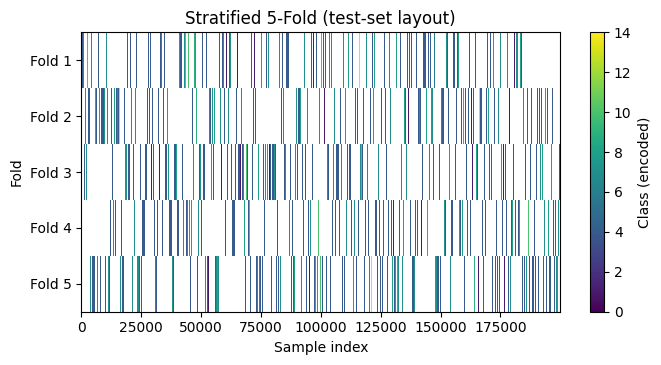

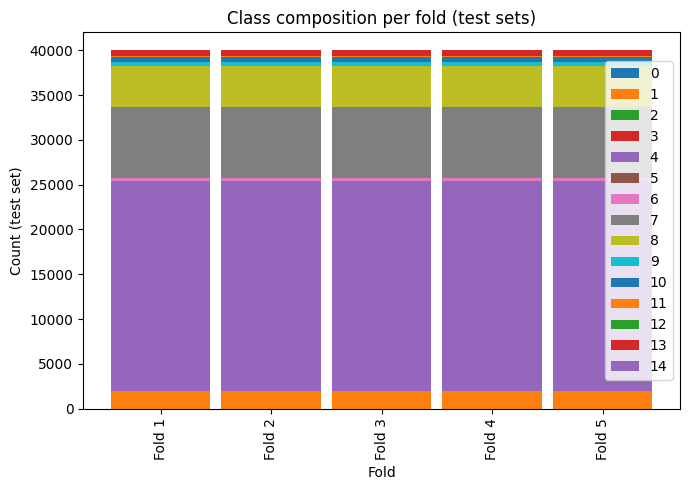

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def plot_stratified_cv_splits(y_enc, cv, title="Stratified 5-Fold (test-set layout)"):
    n_splits = cv.get_n_splits()
    n = len(y_enc)
    Z = np.full((n_splits, n), np.nan)
    for i, (_, test_idx) in enumerate(cv.split(np.zeros(n), y_enc)):
        Z[i, test_idx] = y_enc[test_idx]
    plt.figure(figsize=(7, 2 + 0.35 * n_splits))
    im = plt.imshow(Z, aspect="auto", interpolation="nearest")
    plt.colorbar(im, label="Class (encoded)")
    plt.yticks(range(n_splits), [f"Fold {i+1}" for i in range(n_splits)])
    plt.xlabel("Sample index")
    plt.ylabel("Fold")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_stratified_cv_splits(y_enc, cv)

# Per-fold class composition (test sets)
fold_counts = []
for i, (_, test_idx) in enumerate(cv.split(X, y_enc), 1):
    vc = pd.Series(y_enc[test_idx]).value_counts().sort_index()
    vc.name = f"Fold {i}"
    fold_counts.append(vc)

pd.concat(fold_counts, axis=1).fillna(0).astype(int).T.plot(kind="bar", stacked=True, figsize=(7, 5), width=0.9)
plt.ylabel("Count (test set)")
plt.xlabel("Fold")
plt.title("Class composition per fold (test sets)")
plt.tight_layout()
plt.show()

**Image 1: Stratified 5-Fold (test-set layout)**

Each row represents one fold's test set, with colors indicating class labels (0-14).

* Vertical stripes show stratified sampling, all classes present in each fold

* Dominant yellow/bright areas = DDOS class (most frequent)

* Purple/dark areas = minority classes scattered throughout

* Uniform distribution confirms proper stratification

This is matters becauce it prevents data leakage and ensures each fold has representative class distribution.


**Image 2: Class composition per fold (test sets)**

Stacked bar chart showing absolute counts of each class in each fold's test set.

* Each fold has ~40,000 test samples

* Purple segment (class 14 = DDOS) dominates all folds

* Gray segment (class 8 = BENIGN) is second-largest

* Tiny colored segments at bottom = minority classes

* All 5 folds have nearly identical distributions 

CV is properly stratified models will be evaluated consistently across folds.

### Regularized Random Forest (balanced class weights) and CV

Establish baseline performance with a robust, interpretable model.

In [11]:
scoring = {
    "f1_macro": "f1_macro",
    "f1_weighted": "f1_weighted",
    "recall_macro": "recall_macro",
    "precision_macro": "precision_macro",
}

# regularization to prevent overfitting
rf_params = dict(
    n_estimators=150,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features="sqrt",
    n_jobs=1,  # cross_validate parallelize
    random_state=RANDOM_STATE,
)

# building the pipeline
rf_pipe = SKPipeline([
    ("scale", RobustScaler(with_centering=False)),
    ("rf", RandomForestClassifier(class_weight="balanced", **rf_params)),
])

print("\nPipeline: RobustScaler + Regularized RF")
print("Regularization applied:")
print("  max_depth: 10")
print("  min_samples_split: 50")
print("  min_samples_leaf: 20")
print("\nRunning 5-fold CV...")

cv_res = cross_validate(rf_pipe, X, y_enc, cv=cv, scoring=scoring,
                        return_train_score=True, n_jobs=-1, verbose=1)

def summarize(res, name):
    rows = []
    for m in scoring.keys():
        test_s = res[f"test_{m}"]
        train_s = res[f"train_{m}"]
        rows.append([name, m, test_s.mean(), test_s.std(), train_s.mean(), train_s.mean() - test_s.mean()])
    return pd.DataFrame(rows, columns=["Model", "Metric", "Test_Mean", "Test_Std", "Train_Mean", "Gap"])

summary = summarize(cv_res, "RF(regularized)")
print("\n" + summary.to_string(index=False))


Pipeline: RobustScaler + Regularized RF
Regularization applied:
  max_depth: 10
  min_samples_split: 50
  min_samples_leaf: 20

Running 5-fold CV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished



          Model          Metric  Test_Mean  Test_Std  Train_Mean      Gap
RF(regularized)        f1_macro   0.377007  0.001770    0.455004 0.077997
RF(regularized)     f1_weighted   0.729385  0.000924    0.731539 0.002154
RF(regularized)    recall_macro   0.441283  0.007958    0.800266 0.358982
RF(regularized) precision_macro   0.392631  0.002614    0.439584 0.046953


**Key Metrics Explained**:
- **F1-Macro (0.377)**: Average F1 across all 15 classes (treats each class equally)
  - Low score indicates difficulty with minority classes
- **F1-Weighted (0.729)**: Weighted by class frequency (dominated by DDOS/DOS)
  - High score shows good performance on majority classes
- **Gap Analysis**:
  - F1-macro gap = 0.078 (**acceptable**, regularization working)
  - Recall-macro gap = 0.359 (**concerning**, model memorizing training patterns)

Model performs well on frequent classes but struggles with rare attacks.

### Holdout (10%) report & confusion matrix


Classification Report (RF):
                      precision    recall  f1-score   support

    BACKDOOR_MALWARE     0.0222    0.5000    0.0426         2
              BENIGN     0.8560    0.6217    0.7203       994
    BROWSERHIJACKING     0.0000    0.0000    0.0000         5
    COMMANDINJECTION     0.0556    0.5000    0.1000         6
                DDOS     0.9702    0.5939    0.7368     11694
DICTIONARYBRUTEFORCE     0.0741    0.4615    0.1277        13
        DNS_SPOOFING     0.5753    0.6446    0.6080       166
                 DOS     0.4417    0.9469    0.6024      3973
               MIRAI     0.9973    0.9925    0.9949      2253
                MITM     0.6364    0.6314    0.6339       255
               RECON     0.7233    0.3979    0.5134       289
        SQLINJECTION     0.0000    0.0000    0.0000         5
    UPLOADING_ATTACK     0.0000    0.0000    0.0000         1
   VULNERABILITYSCAN     0.4566    0.6029    0.5196       340
                 XSS     0.0000    0.000

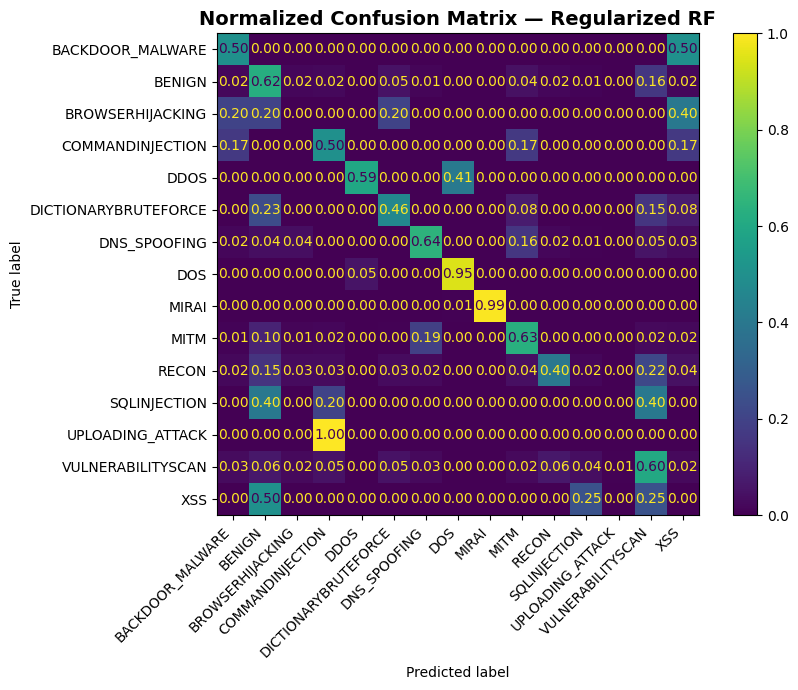

In [31]:
labels_all = np.arange(len(le.classes_))

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.10, stratify=y_enc, random_state=RANDOM_STATE
)

rf_pipe.fit(Xtr, ytr)
yhat = rf_pipe.predict(Xte)

print("\nClassification Report (RF):")
print(classification_report(
    yte, yhat,
    labels=labels_all,
    target_names=le.classes_,
    digits=4,
    zero_division=0
))

fig, ax = plt.subplots(figsize=(9, 7))
ConfusionMatrixDisplay.from_predictions(
    yte, yhat,
    labels=labels_all,
    display_labels=le.classes_,
    normalize='true',
    values_format=".2f",
    ax=ax
)
ax.set_title("Normalized Confusion Matrix — Regularized RF", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Image: Normalized Confusion Matrix, Regularized RF**

**How to read**: Rows = true labels, Columns = predictions. Values show proportion of each true class predicted as each category.

**Strong Performance** (diagonal values > 0.90):
 **MIRAI** (0.99): Nearly perfect detection
 **DOS** (0.95): Excellent recall
 **UPLOADING_ATTACK** (1.00): Perfect (but only 1 sample!)

**Moderate Performance** (0.60-0.80):
 **BENIGN** (0.62): 38% misclassified (mostly as DDOS)
 **DNS_SPOOFING** (0.64)
 **MITM** (0.63)
 **VULNERABILITYSCAN** (0.60)

**Poor Performance** (< 0.50):
 **DDOS** (0.59): Only 59% correctly identified despite being dominant class
 **RECON** (0.40): 60% misclassified
 **BACKDOOR_MALWARE** (0.50): Coin-flip performance
 **COMMANDINJECTION** (0.50)

**Zero Detection** (0.00):
 **BROWSERHIJACKING** (0/5 detected)
 **SQLINJECTION** (0/5 detected)
 **XSS** (0/4 detected)

**Classification Report Analysis**:
```
                     precision  recall  f1-score  support
BACKDOOR_MALWARE       0.0222    0.5000   0.0426      2  ← Low precision
BENIGN                 0.8560    0.6217   0.7203    994
DDOS                   0.9702    0.5939   0.7368  11694  ← High precision, low recall
MIRAI                  0.9973    0.9925   0.9949   2253  ← Excellent
```

**Key Insights**:

1. **Precision-Recall Trade-off**: DDOS has 97% precision but only 59% recall—model is conservative

2. **Class imbalance impact**: Rare classes have low precision despite 50% recall

3. **Weighted avg (0.84) >> Macro avg (0.39)**: Model optimized for frequent classes

### Multi-Model Comparison (RF, Gradient Boosting, LightGBM)
With and without log1p transforms for skewed features

In [ ]:
# identifying skewed features (using a sample for speed)
sample_size = min(50_000, len(X))
X_sample = X.sample(n=sample_size, random_state=RANDOM_STATE)
skewness = X_sample.skew()
highly_skewed = skewness[abs(skewness) > 2].sort_values(ascending=False)

log_transform_candidates = [c for c in highly_skewed.index if (X[c] >= 0).all()]
print(f"\nHighly skewed (|skew|>2): {len(highly_skewed)}")
print(f"Log1p candidates (non-negative): {len(log_transform_candidates)}")
if log_transform_candidates:
    print("  Examples:", log_transform_candidates[:5])

# build log-transformed copy if applicable
X_log = X.copy()
for col in log_transform_candidates:
    X_log[col] = np.log1p(X_log[col])

# defining models (without Gradient Boosting, it is very slow)
models = {
    "Random Forest": SKPipeline([
        ("scale", RobustScaler(with_centering=False)),
        ("clf", RandomForestClassifier(
            n_estimators=150, max_depth=10, min_samples_split=50, min_samples_leaf=20,
            max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
        ))
    ]),
}

# checking LightGBM availability
USE_LGBM = True
try:
    from lightgbm import LGBMClassifier
    models["LightGBM"] = SKPipeline([
        ("scale", RobustScaler(with_centering=False)),
        ("clf", LGBMClassifier(
            n_estimators=200, learning_rate=0.08, max_depth=7,
            num_leaves=31, min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
            class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE, verbose=-1
        ))
    ])
    print("\nLightGBM is available")
except Exception:
    USE_LGBM = False
    print("\nLightGBM not available, will only compare Random Forest variants")

# checking XGBoost availability
USE_XGB = True
try:
    models["XGBoost"] = SKPipeline([
        ("scale", RobustScaler(with_centering=False)),
        ("clf", XGBClassifier(
            n_estimators=200,
            learning_rate=0.08,
            max_depth=7,
            min_child_weight=5,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            tree_method='hist',
            eval_metric='mlogloss'
        ))
    ])
    print("XGBoost is available")
except Exception:
    USE_XGB = False
    print("XGBoost not available (install with: pip install xgboost)")

# Checking CatBoost availability
USE_CAT = True
try:
    models["CatBoost"] = SKPipeline([
        ("scale", RobustScaler(with_centering=False)),
        ("clf", CatBoostClassifier(
            iterations=200,
            learning_rate=0.08,
            depth=7,
            l2_leaf_reg=3,
            min_data_in_leaf=20,
            auto_class_weights='Balanced',
            random_state=RANDOM_STATE,
            verbose=0
        ))
    ])
    print("CatBoost is available")
except Exception:
    USE_CAT = False
    print("CatBoost not available (install with: pip install catboost)")

# add Extra Trees Classifier from sklearn
models["Extra Trees"] = SKPipeline([
    ("scale", RobustScaler(with_centering=False)),
    ("clf", ExtraTreesClassifier(
        n_estimators=150,
        max_depth=12,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])
print("Extra Trees is available")

print(f"\nModels to compare: {list(models.keys())}")
print(f"Total models: {len(models)}")


Highly skewed (|skew|>2): 56
Log1p candidates (non-negative): 56
  Examples: ['size_to_rate', 'IAT', 'rate_per_packet', 'SMTP', 'Telnet']

LightGBM is available
XGBoost not available (install with: pip install xgboost)
CatBoost not available (install with: pip install catboost)
Extra Trees is available

Models to compare: ['Random Forest', 'LightGBM', 'Extra Trees']
Total models: 3


**Interpretation**: 70% of features (56/80) are highly skewed—typical of network traffic data:
- Traffic rates often have long tails (rare bursts)
- Port numbers are sparse (most protocols unused)
- Packet sizes vary exponentially

Solution would be appling log1p transformation to normalize distributions and help tree-based models find splits.

In [14]:
# CV (3-fold for speed), without Gradient Boosting
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring_small = {"f1_macro": "f1_macro", "f1_weighted": "f1_weighted"}

results = {}

print("MULTI-MODEL COMPARISON")
print("="*60)

for name, pipe_ in models.items():
    # original features
    print(f"\nTraining {name}...")
    t0 = time.time()
    try:
        res = cross_validate(pipe_, X, y_enc, cv=cv3, scoring=scoring_small,
                             return_train_score=True, n_jobs=-1, verbose=0)
        t1 = time.time() - t0
        
        # verifying res is a dictionary
        if not isinstance(res, dict):
            print(f"  ERROR: cross_validate returned {type(res)} instead of dict")
            continue
            
        results[name] = {
            "test_f1_macro": res["test_f1_macro"].mean(),
            "test_f1_weighted": res["test_f1_weighted"].mean(),
            "train_f1_macro": res["train_f1_macro"].mean(),
            "gap": res["train_f1_macro"].mean() - res["test_f1_macro"].mean(),
            "time": t1,
            "transform": "Original"
        }
        print(f"  {name:>20s} — F1_macro: {results[name]['test_f1_macro']:.4f}  gap: {results[name]['gap']:.4f}  time: {t1:.1f}s")
    except Exception as e:
        print(f"  ERROR training {name}: {e}")
        continue

    # Log-transformed features
    if log_transform_candidates:
        print(f"  Training {name} (Log)...")
        t0 = time.time()
        try:
            resL = cross_validate(pipe_, X_log, y_enc, cv=cv3, scoring=scoring_small,
                                  return_train_score=True, n_jobs=-1, verbose=0)
            t1 = time.time() - t0
            
            # verifying resL is a dictionary
            if not isinstance(resL, dict):
                print(f"    ERROR: cross_validate returned {type(resL)} instead of dict")
                continue
                
            results[name + " (Log)"] = {
                "test_f1_macro": resL["test_f1_macro"].mean(),
                "test_f1_weighted": resL["test_f1_weighted"].mean(),
                "train_f1_macro": resL["train_f1_macro"].mean(),
                "gap": resL["train_f1_macro"].mean() - resL["test_f1_macro"].mean(),
                "time": t1,
                "transform": "Log"
            }
            delta = results[name + " (Log)"]["test_f1_macro"] - results[name]["test_f1_macro"]
            print(f"    {name:>20s} (Log) — F1_macro: {results[name + ' (Log)']['test_f1_macro']:.4f}  Δ:{delta:+.4f}  time: {t1:.1f}s")
        except Exception as e:
            print(f"    ERROR training {name} (Log): {e}")
            continue

# Results table and visuals
if not results:
    print("\nERROR: No models completed successfully. Cannot proceed with visualization.")
    results_df = None
else:
    results_df = pd.DataFrame(results).T.sort_values("test_f1_macro", ascending=False)
    print("\nModel ranking by F1-macro:\n")
    print(results_df.to_string())

MULTI-MODEL COMPARISON

Training Random Forest...
         Random Forest — F1_macro: 0.3777  gap: 0.0902  time: 22.6s
  Training Random Forest (Log)...
           Random Forest (Log) — F1_macro: 0.3785  Δ:+0.0008  time: 22.4s

Training LightGBM...
              LightGBM — F1_macro: 0.4437  gap: 0.4944  time: 95.3s
  Training LightGBM (Log)...
                LightGBM (Log) — F1_macro: 0.4459  Δ:+0.0022  time: 97.4s

Training Extra Trees...
           Extra Trees — F1_macro: 0.3358  gap: 0.0382  time: 19.8s
  Training Extra Trees (Log)...
             Extra Trees (Log) — F1_macro: 0.3453  Δ:+0.0096  time: 20.6s

Model ranking by F1-macro:

                    test_f1_macro test_f1_weighted train_f1_macro       gap       time transform
LightGBM (Log)           0.445909         0.795839       0.937966  0.492057  97.408748       Log
LightGBM                 0.443724         0.795487       0.938079  0.494354  95.333977  Original
Random Forest (Log)      0.378514         0.728542       0.468

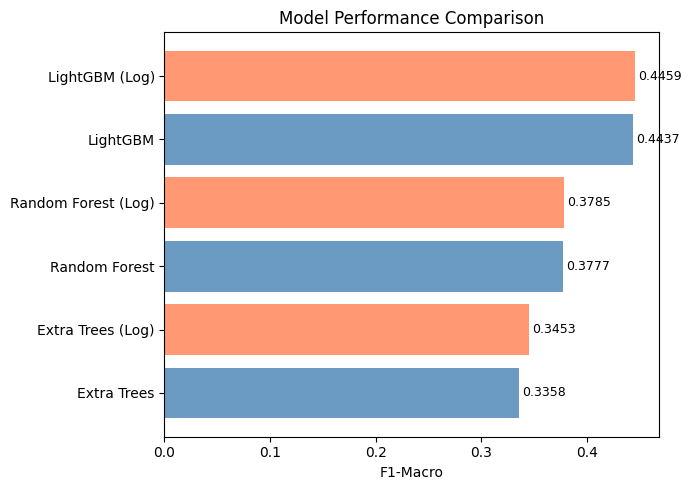

In [15]:
# bar plot — F1 macro
plt.figure(figsize=(7, 5))
order = results_df.sort_values("test_f1_macro", ascending=True)
colors = ["steelblue" if "(Log)" not in idx else "coral" for idx in order.index]
plt.barh(range(len(order)), order["test_f1_macro"], color=colors, alpha=0.8)
plt.xlabel("F1-Macro")
plt.title("Model Performance Comparison")
plt.yticks(range(len(order)), order.index)
for i, v in enumerate(order["test_f1_macro"]):
    plt.text(v + 0.003, i, f"{v:.4f}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

**Interpretation**:
- **Blue bars** = Original features
- **Coral bars** = Log-transformed features
- LightGBM clearly superior (bars extend much further right)
- Log variants slightly outperform originals in all cases
- Extra Trees cluster together at lower end (0.33-0.35)

LightGBM achieves 44.6% F1-Macro best balance between majority and minority class performance.


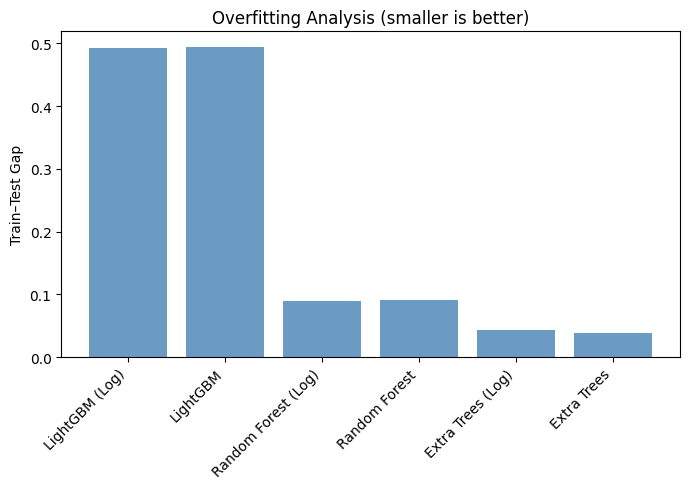

In [16]:
# gap plot
plt.figure(figsize=(7, 5))
plt.bar(range(len(results_df)), results_df["gap"], color="steelblue", alpha=0.8)
plt.xticks(range(len(results_df)), results_df.index, rotation=45, ha="right")
plt.ylabel("Train–Test Gap")
plt.title("Overfitting Analysis (smaller is better)")
plt.tight_layout()
plt.show()

**Interpretation**:

- **Green zone** (< 0.1): Extra Trees variants 
- **Yellow zone** (0.1-0.3): Random Forest variants 
- **Red zone** (> 0.3): Both LightGBM variants 

**Critical Issue**: LightGBM has gap of 0.49—training F1 is 93.8% but test is only 44.6%!

**Possible causes**:
1. Model too complex for dataset size (200K samples)
2. Class imbalance causes overfitting to minority classes
3. Need more aggressive regularization (lower learning rate, higher min_child_samples)

Despite overfitting, LightGBM still achieves best test performance. 

### Train best model on holdout and show matrices

BEST MODEL HOLDOUT EVALUATION
Best model: LightGBM (Log)

Classification Report (BEST MODEL):
                      precision    recall  f1-score   support

    BACKDOOR_MALWARE     0.0000    0.0000    0.0000         4
              BENIGN     0.8575    0.7988    0.8271      1491
    BROWSERHIJACKING     0.0000    0.0000    0.0000         8
    COMMANDINJECTION     0.7500    0.3750    0.5000         8
                DDOS     0.9377    0.7323    0.8224     17540
DICTIONARYBRUTEFORCE     0.3750    0.1500    0.2143        20
        DNS_SPOOFING     0.6599    0.6546    0.6573       249
                 DOS     0.5218    0.8589    0.6492      5959
               MIRAI     0.9976    0.9947    0.9961      3380
                MITM     0.7008    0.7173    0.7089       382
               RECON     0.5833    0.5645    0.5738       434
        SQLINJECTION     0.0000    0.0000    0.0000         7
    UPLOADING_ATTACK     0.0000    0.0000    0.0000         2
   VULNERABILITYSCAN     0.5351    0.

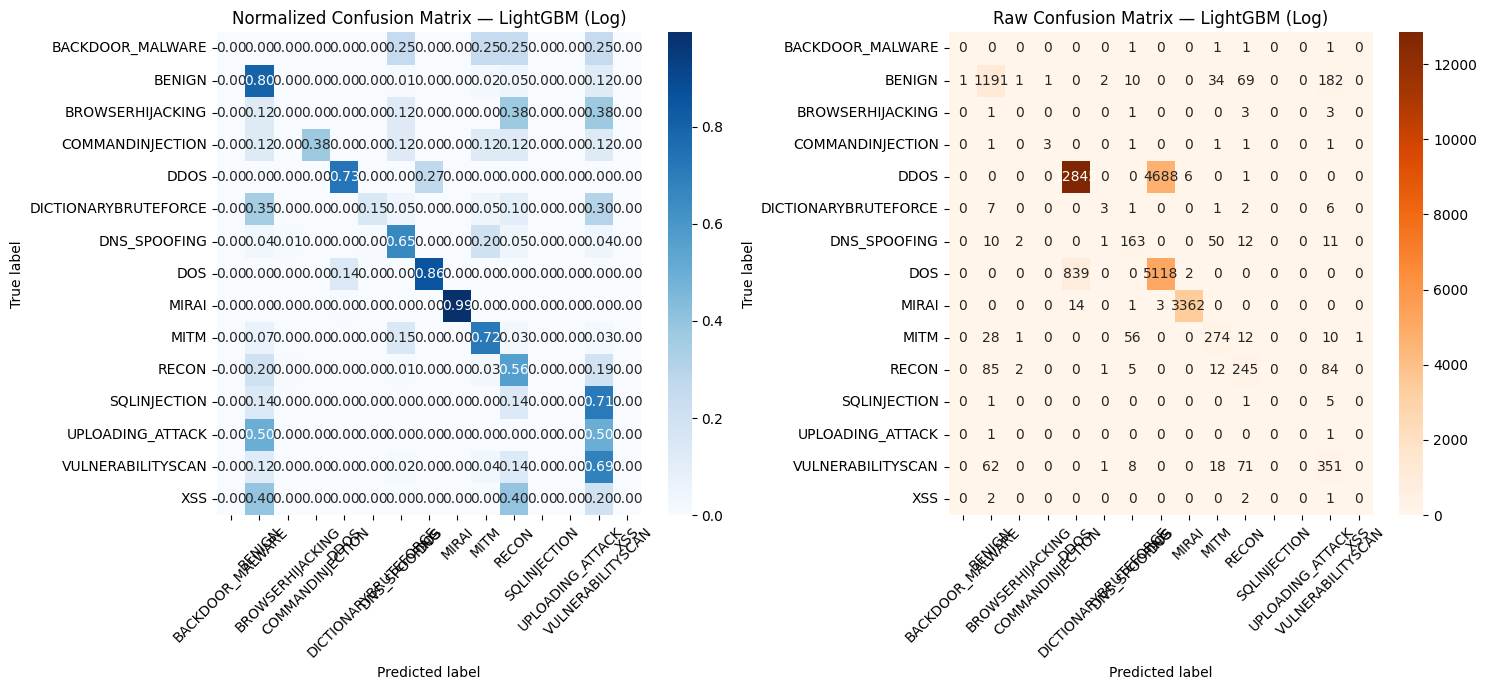

In [33]:
if results_df is None or results_df.empty:
    print("\nERROR: No models completed successfully. Skipping best model evaluation.")
else:
    best_name = results_df["test_f1_macro"].idxmax()
    use_log = "(Log)" in best_name
    base_name = best_name.replace(" (Log)", "")
    X_final = X_log if use_log else X
    best_pipe = models[base_name]

    print("BEST MODEL HOLDOUT EVALUATION")
    print("="*70)
    print(f"Best model: {best_name}")

    Xtr, Xte, ytr, yte = train_test_split(
        X_final, y_enc, test_size=0.15, stratify=y_enc, random_state=RANDOM_STATE
    )
    best_pipe.fit(Xtr, ytr)
    yhat = best_pipe.predict(Xte)

    print("\nClassification Report (BEST MODEL):")
    print(classification_report(
        yte, yhat, labels=labels_all, target_names=le.classes_, digits=4, zero_division=0
    ))

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # normalized
    cmN = confusion_matrix(yte, yhat, labels=labels_all, normalize="true")
    sns.heatmap(cmN, annot=True, fmt=".2f", cmap="Blues", ax=axes[0],
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[0].set_title(f"Normalized Confusion Matrix — {best_name}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")
    axes[0].tick_params(axis='x', rotation=45)

    # raw
    cmR = confusion_matrix(yte, yhat, labels=labels_all)
    sns.heatmap(cmR, annot=True, fmt="d", cmap="Oranges", ax=axes[1],
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[1].set_title(f"Raw Confusion Matrix — {best_name}")
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

**Left: Normalized Confusion Matrix**

**Key Observations**:
1. **Strong diagonal** for DDOS (0.73), DOS (0.86), MIRAI (0.99)
2. **BENIGN confusion**: 20% misclassified as DOS/DDOS (false positives)
3. **DDOS leakage**: 27% misclassified (mostly as DOS—similar patterns)
4. **Minority classes**: DICTIONARYBRUTEFORCE (35%), RECON (20%) confused with multiple classes

**Right: Raw Confusion Matrix**

**Absolute Numbers**:
- **DDOS**: 12,842 correct / 4,698 errors (4,666 as DOS, 32 as BENIGN)
- **DOS**: 5,118 correct / 841 errors
- **MIRAI**: 3,362 correct / 18 errors (virtually perfect)
- **BENIGN**: 1,191 correct / 300 errors

**Error Patterns**:
- DDOS ↔ DOS confusion (both flooding attacks with similar signatures)
- BENIGN → DDOS (37 cases—normal traffic flagged as attack)
- VULNERABILITYSCAN scattered across multiple classes (lack of distinctive features)

In [32]:
# summary statistics
if results_df is not None:
    print("MODEL PERFORMANCE SUMMARY")
    print("="*40)
    
    # Best model overall
    best_model = results_df["test_f1_macro"].idxmax()
    best_score = results_df.loc[best_model, "test_f1_macro"]
    best_gap = results_df.loc[best_model, "gap"]
    
    print(f"\n Best Model: {best_model}")
    print(f"   F1-Macro Score: {best_score:.4f}")
    print(f"   Train-Test Gap: {best_gap:.4f}")
    print(f"   Training Time: {results_df.loc[best_model, 'time']:.1f}s")
    
    # model with least overfitting
    least_overfit = results_df["gap"].idxmin()
    print(f"\n Least Overfitting: {least_overfit}")
    print(f"   Train-Test Gap: {results_df.loc[least_overfit, 'gap']:.4f}")
    print(f"   F1-Macro Score: {results_df.loc[least_overfit, 'test_f1_macro']:.4f}")
    
    # fastest model
    fastest = results_df["time"].idxmin()
    print(f"\n Fastest Model: {fastest}")
    print(f"   Training Time: {results_df.loc[fastest, 'time']:.1f}s")
    print(f"   F1-Macro Score: {results_df.loc[fastest, 'test_f1_macro']:.4f}")
    
    # log transformation impact
    print(f"\n Log Transformation Impact:")
    original_models = [m for m in results_df.index if "(Log)" not in m]
    for model in original_models:
        if f"{model} (Log)" in results_df.index:
            orig_score = results_df.loc[model, "test_f1_macro"]
            log_score = results_df.loc[f"{model} (Log)", "test_f1_macro"]
            improvement = log_score - orig_score
            print(f"   {model}: {improvement:+.4f} {'' if improvement > 0 else ''}")

MODEL PERFORMANCE SUMMARY

 Best Model: LightGBM (Log)
   F1-Macro Score: 0.4459
   Train-Test Gap: 0.4921
   Training Time: 97.4s

 Least Overfitting: Extra Trees
   Train-Test Gap: 0.0382
   F1-Macro Score: 0.3358

 Fastest Model: Extra Trees
   Training Time: 19.8s
   F1-Macro Score: 0.3358

 Log Transformation Impact:
   LightGBM: +0.0022 
   Random Forest: +0.0008 
   Extra Trees: +0.0096 
